# Sentinel 2 + Landsat animation with hydrograph

In [10]:
# Import modules
import datacube 
import sys
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from skimage import exposure
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datetime import datetime, timedelta

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting
import TasseledCapTools
import animate_shp

# Set up datacube instances
dc = datacube.Datacube(app='Time series animation')
s2dc = datacube.Datacube(config='/g/data/r78/dc_configs/sentinel2.conf')

# Study area name used for output file
study_area = 'macmarsh'

# Thresholds used for cloud masking (Sentinel 2 is more aggressive)
landsat_masked_prop = 0.99
sentinel_masked_prop = 0.90

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -30.72360833, 147.53250000, 5000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2015-01-01', '2018-07-30'),
         'crs': 'EPSG:3577'}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract cloud-free clear Landsat and Sentinel observations
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. 

Load in Sentinel data for S2A and S2B.

In [3]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# Load in data
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                                        #bands_of_interest=['green', 'nir', 'swir1', 'red'], 
                                        masked_prop=landsat_masked_prop, mask_dict=custom_mask, apply_mask=False)  

# Remove problematic timesteps
problem_times = ['2015-08-02', '2015-08-18', '2016-03-13', '2016-04-30', '2017-05-03', '2015-04-28']
times_to_drop = [ls578_ds.time.loc[i].values for i in problem_times]

# Remove timesteps
ls578_ds = ls578_ds.drop(np.concatenate(times_to_drop), dim="time")


Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 53 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


## Import Sentinel 2

In [4]:
# Load Sentinel
s2a_ds = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          #measurements = ['swir1', 'nir1', 'green', 'pixel_quality'], 
                   like=ls578_ds)

s2b_ds = s2dc.load(product='s2b_ard_granule', group_by='solar_day', 
                          #measurements = ['swir1', 'nir1', 'green', 'pixel_quality'], 
                   like=ls578_ds)

# Keep only cloud-free Sentinel 2A data
PQmask = s2a_ds.where(s2a_ds.pixel_quality == 1)
threshold = s2a_ds.x.count() * s2a_ds.y.count() * (1.0 - sentinel_masked_prop)
KeepTimeMask = PQmask.green.isnull().sum(axis=(1, 2)) <= int(threshold)
s2a_ds = s2a_ds.where(KeepTimeMask).dropna(dim='time')

# Keep only cloud-free Sentinel 2B data
PQmask = s2b_ds.where(s2b_ds.pixel_quality == 1)
threshold = s2b_ds.x.count() * s2b_ds.y.count() * (1.0 - sentinel_masked_prop)
KeepTimeMask = PQmask.green.isnull().sum(axis=(1, 2)) <= int(threshold)
s2b_ds = s2b_ds.where(KeepTimeMask).dropna(dim='time')


/g/data/v10/public/modules/dea/20180705/lib/python3.6/site-packages/datacube/api/query.py:96: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:
/g/data/v10/public/modules/dea/20180705/lib/python3.6/site-packages/datacube/api/query.py:96: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


## Import flow data
This is used to plot a line on the right panel of the animation. Must be imported as a geopandas dataframe with a datetime index column

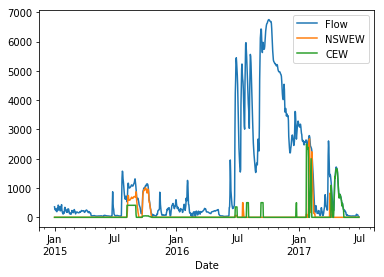

In [5]:
# Set area over which index values should be averaged
line_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Enviroflows/raw_data/macmarsh/FlowData.csv', index_col='Date', usecols=[0,1,2,3], parse_dates=True, dayfirst=True)

# Subset to time covered by datacube query
date_min, date_max = query['time']
line_df = line_df[(line_df.index >= date_min) & (line_df.index <= date_max)]

# Give informative name
# line_df['Max discharge (Ml/d)'] = line_df['mean'] * 2
line_df.rename(columns={'mean':'Mean discharge (Ml/d)'}, inplace=True)
line_df.plot()


In [6]:
# Combine into single dataset
s2a_ds.rename({'nir1': 'nir'}, inplace=True)
s2b_ds.rename({'nir1': 'nir'}, inplace=True)
combined_ds = xr.auto_combine([ls578_ds, s2a_ds, s2b_ds])
combined_ds = combined_ds.sortby('time')
combined_ds

<xarray.Dataset>
Dimensions:        (time: 112, x: 401, y: 401)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01T00:01:28.500000 ...
  * y              (y) float64 -3.429e+06 -3.429e+06 -3.429e+06 -3.429e+06 ...
  * x              (x) float64 1.463e+06 1.463e+06 1.463e+06 1.464e+06 ...
Data variables:
    blue           (time, y, x) float64 895.0 916.0 909.0 871.0 900.0 889.0 ...
    green          (time, y, x) float64 1.369e+03 1.383e+03 1.362e+03 ...
    red            (time, y, x) float64 1.831e+03 1.853e+03 1.825e+03 ...
    nir            (time, y, x) float64 2.973e+03 2.994e+03 2.959e+03 ...
    swir1          (time, y, x) float64 3.95e+03 3.97e+03 3.913e+03 ...
    swir2          (time, y, x) float64 3.233e+03 3.252e+03 3.219e+03 ...
    data_perc      (time) float64 1.0 1.0 0.9982 1.0 1.0 1.0 1.0 1.0 1.0 nan ...
    pixel_quality  (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    contiguity     (time, y, x) float64 nan nan nan nan nan nan nan nan 

In [7]:
tci = TasseledCapTools.thresholded_tasseled_cap(combined_ds, wetness_threshold=-350, drop_tc_bands=False)

In [8]:
tci.wetness_thresholded.min()

<xarray.DataArray 'wetness_thresholded' ()>
array(-350.)

In [9]:
tci.wetness_thresholded.max()

<xarray.DataArray 'wetness_thresholded' ()>
array(1255.0667)

## Plot data as animation

    Exporting animation to macmarsh_wetness_shp_sentinel2.gif


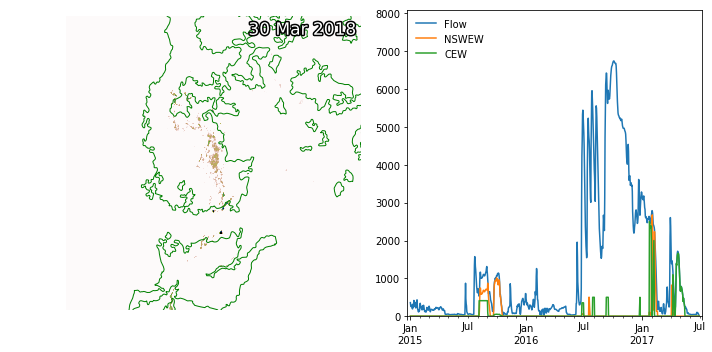

In [33]:
animate_shp.animated_timeseriesline(ds=tci,#).isel(time=[0,1,2,3,4,5]), 
                        df=line_df, 
                        output_path='{}_wetness_shp_sentinel2.gif'.format(study_area), 
                        bands=['wetness'], 
                        onebandplot_cbar=False, 
                        onebandplot_kwargs={'cmap':'gist_earth_r','vmin':-600,
                                           'vmax':0},
                        shapefile_path=['/g/data/r78/rt1527/dea-notebooks/Enviroflows/raw_data/macmarsh/redgumreeds_gums.shp'],#,'/g/data/r78/rt1527/dea-notebooks/Enviroflows/raw_data/macmarsh/redgumreeds_reeds.shp'],
                        shapefile_kwargs={'linewidth':1, 'edgecolor':'green'},
                        interval=220, 
                        annotation_kwargs={'fontsize':17},
                        reflect_stand=4200)

In [28]:
# # Create animation
# DEAPlotting.animated_timeseriesline(ds=tci,#.isel(time=[0,1,2,3,4,5]), 
#                         df=line_df, 
#                         output_path='{}_wetness_test_sentinel2.gif'.format(study_area), 
#                         bands=['wetness'], 
#                         onebandplot_cbar=False, 
#                         onebandplot_kwargs={'cmap':'gist_earth_r','vmin':-600,
#                                            'vmax':0},
#                         interval=220, 
#                         annotation_kwargs={'fontsize':17},
#                         reflect_stand=4200)